### Preliminaries

This code builds cross-sectional portfolio strategies and produces relevant analytics.

In [2]:
import qpm_download
import qpm
import pandas as pd
import numpy as np
import wrds
import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import_data = False             # <-- Edit this line
_DATA_DIR = '/Users/jiahongcai/Desktop/Quantitative Strategies/Data'           # <-- Edit this line
_STRATEGY_DIR = '/Users/jiahongcai/Desktop/Quantitative Strategies/Strategies/Return'   # <-- Edit this line

Next, we specify the strategy settings.
- First, we select the strategy name. At this point, we have `Value` and `Size`. We'll add more later.
- We can sort every month (`Monthly`) or only in June (`June`). As accounting data mostly comes out quarterly or annually, sorting once a year is often sufficient. As most companies have their fiscal year end in December, and we wait six months to make sure the data are available to investors, we sort in June.
- We can set `_REMOVE_MICRO_CAPS` to either `False` or `True`. If `True`, then we drop the smallest stocks. 
- The next two lines select the sample. 
- The final line selects the number of portfolios. We typically set this to 5 or 10.

In [4]:
_STRATEGY_NAME = 'ESG'      
_SORT_FREQUENCY = 'June'        # Either "Monthly" or "June"

_REMOVE_MICRO_CAPS = False      # Either "True" or "False"
_SAMPLE_START = '2014-01-01'
_SAMPLE_END = '2023-07-31'
_NUM_PORT = 5

### Step 1. Construct Signal
Let's first see which variables are available in the data

In [5]:
qpm.list_variables(data_dir = _DATA_DIR, file_name = 'MasterData.parquet')

Identifiers:
['permno', 'ticker', 'comnam', 'gvkey', 'conm', 'cusip', 'lpermco']

Prices and Returns:
['ret', 'retx', 'prc', 'prcc_c', 'prcc_f', 'vwretd', 'ewretd']

Fama-French:
['mktrf', 'smb', 'hml', 'rf', 'umd', 'rmw', 'cma']

Fundamentals:
['aco', 'act', 'ajex', 'am', 'ao', 'ap', 'at', 'capx', 'che', 'cogs', 'csho', 'cshrc', 'dcpstk', 'dcvt', 'dlc', 'dlcch', 'dltis', 'dltr', 'dltt', 'dm', 'dp', 'drc', 'drlt', 'dv', 'dvc', 'dvp', 'dvpa', 'dvpd', 'dvpsx_c', 'dvt', 'ebit', 'ebitda', 'emp', 'epspi', 'epspx', 'fatb', 'fatl', 'ffo', 'fincf', 'fopt', 'gdwl', 'gdwlia', 'gdwlip', 'gwo', 'ib', 'ibcom', 'intan', 'invt', 'ivao', 'ivncf', 'ivst', 'lco', 'lct', 'lo', 'lt', 'mib', 'msa', 'ni', 'nopi', 'oancf', 'ob', 'oiadp', 'oibdp', 'pi', 'ppenb', 'ppegt', 'ppenls', 'ppent', 'prstkc', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'rect', 'recta', 'revt', 'sale', 'scstkc', 'seq', 'spi', 'sstk', 'tstkp', 'txdb', 'txdi', 'txditc', 'txfo', 'txfed', 'txp', 'txt', 'wcap', 'wcapch', 'xacc', 'xad', 'xint

We will work initially with a smaller data set MasterData_small.parquet, which is less demanding in terms of your computer's memory.

In [6]:
qpm.list_variables(data_dir = _DATA_DIR, file_name = 'MasterData_small.parquet')

Identifiers:
['permno', 'ticker', 'comnam', 'conm']

Prices and Returns:
['ret', 'retx', 'prc', 'vwretd']

Fama-French:
['mktrf', 'smb', 'hml', 'rf', 'umd', 'rmw', 'cma']

Fundamentals:
['at', 'cogs', 'revt', 'be']

Others:
['vol', 'me', 'ESG_score', 'E_score', 'S_score', 'G_score', 'carbon_intensity']



#### Load Data
Startegies differ by the signals that they use, and the signals use differ input data. Thus, we first construct the list of fundamentals that we need to load given the strategy that we specified in `_STRATEGY_NAME`. If you change the strategy, then you can change the list of variables you need here.

In [7]:
signal_variables = qpm.return_signal(_STRATEGY_NAME)
signal_variables

['carbon_intensity']

Given the list of fundamentals needed to construct the strategy in `_STRAGEY_NAME`, which is in `signal_variables`, we proceed by loading the relevant data.

In [8]:
if import_data == True:

    df_full = qpm_download.cross_section_compact(_SAMPLE_START, _SAMPLE_END, _STRATEGY_NAME, signal_variables)
    
if import_data == False:
    
    df_full = qpm.load_data(data_dir = _DATA_DIR, file_name = 'MasterData_small.parquet', variable_list = signal_variables)


> Loading Raw Data...
> Renaming key variables...
> Dropping duplicates...
> Creating Auxiliary Variables...


#### Plot Key Variables
We first list the columns in our data

In [9]:
df_full.columns

Index(['cma', 'me', 'shrcd', 'ticker', 'umd', 'mktrf', 'rf', 'prc', 'cogs',
       'rmw', 'revt', 'hml', 'at', 'shrout', 'be', 'conm', 'carbon_intensity',
       'vol', 'permno', 'daret', 'ldate', 'smb', 'exchcd', 'retx', 'profitA',
       'ldate_lag', 'screen', 'ldate_lag12', 'screen12', 'me_lagged'],
      dtype='object')

Next, we plot a variable of interest, such as in this case a stock's market capitalization.

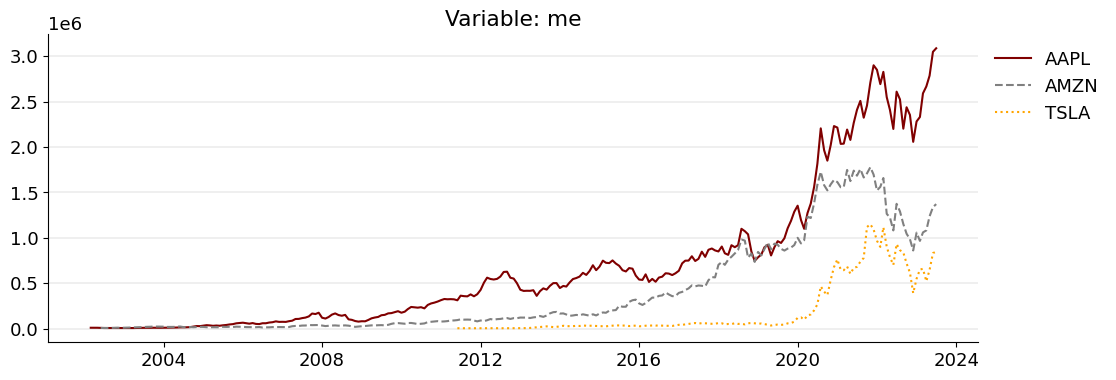

In [10]:
qpm.plot_variables(df_full, variable_list = ['me'],  id_type = 'ticker', id_list = ['AAPL', 'AMZN', 'TSLA'],
                     start_date = '1999-01-01', end_date = '2023-07-31')

#### Construct Signal

In [11]:
if _STRATEGY_NAME == 'Size':

	df_full['signal'] = 1 / df_full['me']
	
elif _STRATEGY_NAME == 'Value':

	df_full['signal'] = df_full['be'] / df_full['me']	
    
elif _STRATEGY_NAME == 'ESG':
    df_full['signal'] = 1 / df_full['carbon_intensity']
        
else:
	
	raise Exception('Please provide a valid _STRATEGY_NAME..')  
    
df_sum = df_full.sort_values(['ldate','ticker'])	
print(df_sum[['ldate','ticker','me','signal','daret']].loc[df_sum['ticker'].isin(['AAPL', 'AMZN', 'TSLA'])].tail(3))    

             ldate ticker            me  signal     daret
121071  2023-07-01   AAPL  3.089904e+06     NaN  0.012785
691699  2023-07-01   AMZN  1.371604e+06     NaN  0.025468
1074188 2023-07-01   TSLA  8.488228e+05     NaN  0.021622


#### Sample Selection

We lag the signal by one month and select the relevant sample (i.e., the sample period and whether we include micro caps or not).

In [13]:
# Lag signal by one period so that the signal value is known at the time of portfolio creation
df_full['signal'] = qpm.create_lag(df_full, var_name = 'signal', lag = 1)

# Select the relevant sample
df = qpm.select_sample(df_full, sample_start = _SAMPLE_START, sample_end = _SAMPLE_END, remove_micro_caps = _REMOVE_MICRO_CAPS)

> Selecting Sample for Given Criteria...


### Step 2. Portfolio Construction
Next, we sort the stocks into portfolios:
- retP_rank_longonly: Rank-based long-only portfolio
- retP_rank_longshort: Rank-based long-short portfolio
- retP_vw_P1, ..., retP_vw_P5: The returns on the 5 portfolios sorted by the signal (value or size) and weighted by market capitalization
- retF_vw: The return on the factor, which is retP_vw_P5-retP_vw_P1

In [14]:
df, df_rets = qpm.create_portfolios(df, sort_frequency = _SORT_FREQUENCY, num_port = _NUM_PORT)
print(df_rets.tail())

> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...


/Users/jiahongcai/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/jiahongcai/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/jiahongcai/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/jiahongcai/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/jiahongcai/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/jiahongcai/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtr

         ldate  retP_rank_longonly  retP_rank_longshort  retP_vw_P1  \
105 2022-10-01            0.079015            -0.005943    0.102167   
106 2022-11-01           -0.002191            -0.065637    0.103097   
107 2022-12-01           -0.069775            -0.025486   -0.049568   
108 2023-01-01            0.163959            -0.031518    0.103510   
109 2023-02-01            0.021614            -0.073882         NaN   

     retP_vw_P2  retP_vw_P3  retP_vw_P4  retP_vw_P5   retF_vw  
105    0.077464   -0.050376    0.054061    0.186190  0.084022  
106   -0.005757    0.087893   -0.107866    0.053285 -0.049812  
107   -0.058569    0.022319   -0.064293   -0.026271  0.023296  
108    0.193290    0.154794    0.052353    0.157603  0.054093  
109         NaN   -0.050707   -0.099146   -0.016760       NaN  


### Step 3. Portfolio Analytics

We first plot the average returns on the portfolios. Then, we plot the cumulative returns on various strategies. For the long-only strategy, we use the market as a simple benchmark. For the long-short strategies, we use the risk-free rate as a benchmark. Later, we will use regression analysis to properly correct for the factors.

> Merging strategy returns with Fama and French factor returns...


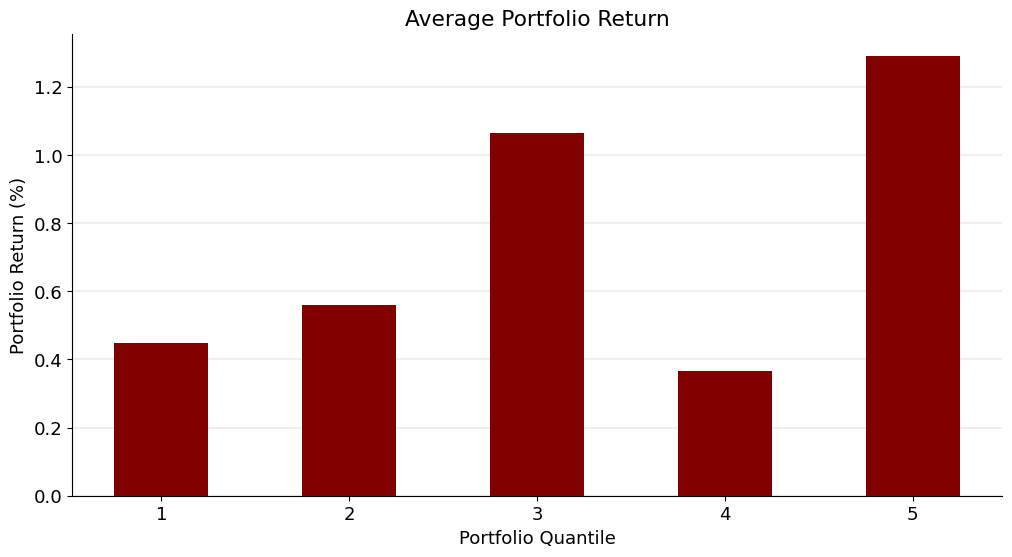

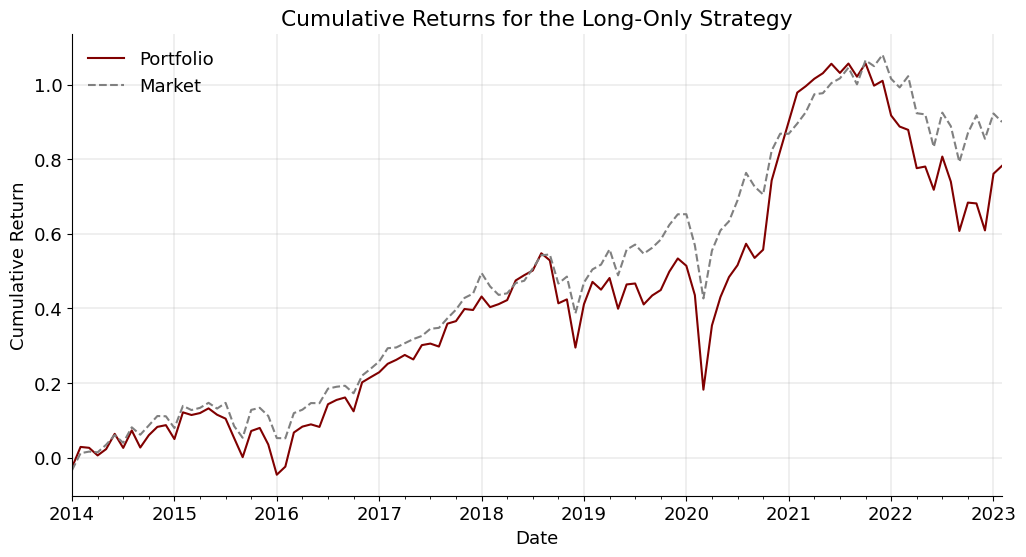

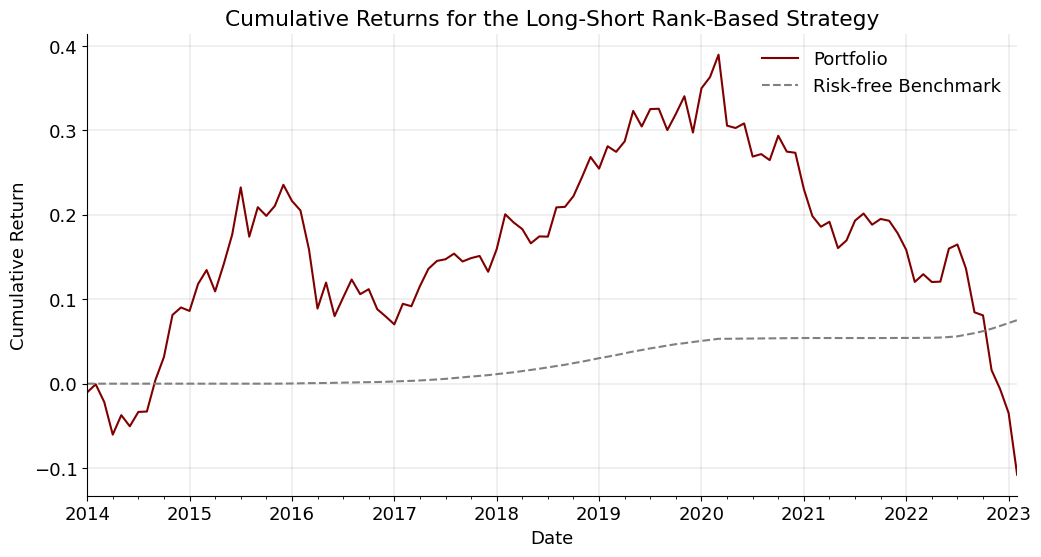

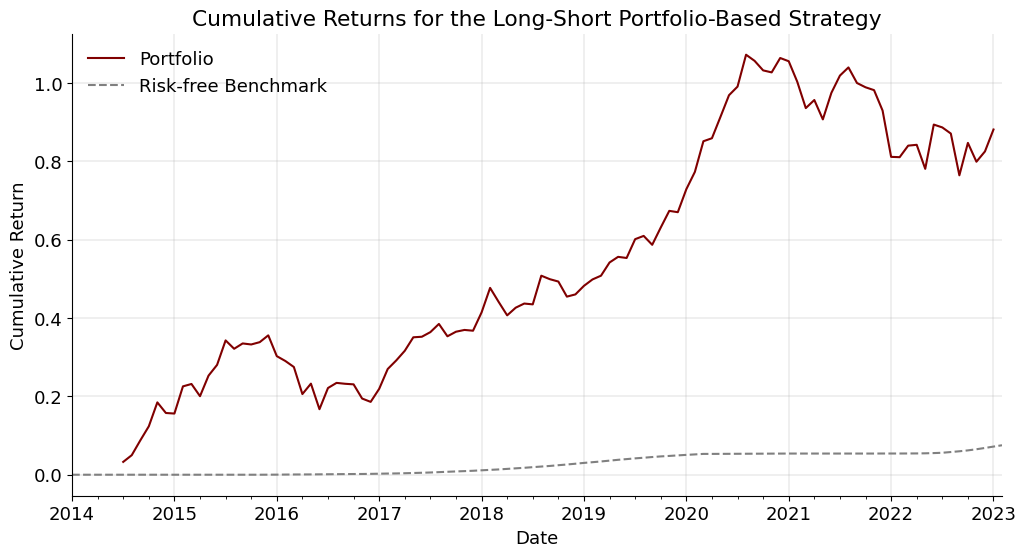

In [15]:
qpm.analyze_strategy(df_rets, analysis_type = 'Performance')

In [16]:
qpm.analyze_strategy(df_rets, analysis_type = 'Summary')

> Merging strategy returns with Fama and French factor returns...
                     count      mean       std       min       25%       50%  \
retP_rank_longonly   110.0  0.008965  0.060641 -0.223824 -0.020517  0.012132   
retP_rank_longshort  110.0 -0.001289  0.027519 -0.080595 -0.017927  0.000304   
retF_vw              103.0  0.008725  0.040852 -0.111536 -0.011645  0.007753   
mktrf                110.0  0.008565  0.045763 -0.133900 -0.018650  0.011450   
smb                  110.0 -0.000743  0.027880 -0.082800 -0.020375  0.000900   
hml                  110.0 -0.000993  0.036690 -0.138700 -0.020575 -0.004750   

                          75%       max  
retP_rank_longonly   0.036694  0.203962  
retP_rank_longshort  0.020107  0.057462  
retF_vw              0.035598  0.119099  
mktrf                0.031725  0.136500  
smb                  0.016400  0.071100  
hml                  0.016825  0.127500  


In [17]:
qpm.analyze_strategy(df_rets, analysis_type = 'Factor Regression')

> Merging strategy returns with Fama and French factor returns...

---------------------------------------------------------------
> Running Factor Regressions: Table 1  - 3 Fama-French Factors
---------------------------------------------------------------

                 (1)       (2)      (3)       (4)        (5)       (6)    
--------------------------------------------------------------------------
const          0.0076*  -0.0027   0.0006   0.0067**   -0.0009   -0.0001   
               (0.0041) (0.0025)  (0.0027) (0.0031)   (0.0014)  (0.0025)  
mktrf          0.1265   1.2182*** -0.0915  0.1344*    1.0648*** -0.0591   
               (0.0860) (0.0535)  (0.0567) (0.0701)   (0.0317)  (0.0550)  
hml                                        -0.7000*** -0.0051   -0.2562***
                                           (0.0857)   (0.0387)  (0.0672)  
smb                                        0.0088     0.7853*** -0.1474   
                                           (0.1201)   (0.0543)  (0

In [18]:
if _REMOVE_MICRO_CAPS:
    save_dir = '%s/StrategyReturns_%s_%s_noMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)
else:
    save_dir = '%s/StrategyReturns_%s_%s_withMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)

df_rets.to_csv(save_dir)
print('Saved Strategy Returns to %s' %(save_dir))

Saved Strategy Returns to /Users/jiahongcai/Desktop/Quantitative Strategies/Strategies/Return/StrategyReturns_ESG_June_withMicroCaps.csv
